# Feature Engineering
Working with stock data, I'm not that surprised my original data isn't "normal". In this segment, my goals are to work with my previously identified small group of stocks in order to impute missing data from SEC filings, and compute percentage changes between one filing and the next. Perhaps I will find that percentage change numbers achieve a more normal distribution. Otherwise, I will need to use entirely nonparametric methods of machine learning in future steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('hf-3-day-prices.csv', parse_dates=['date', 'date_minus1', 'date_plus1'])

### Preliminary work from EDA:
1. Collect "tech stock" tickers with the most complete "revenue" column
2. Drop any completely null columns
3. Drop the "split coefficient" columns, they are always 1 in this group of data

In [2]:
# most complete revenues data
tech_revenues = ['CSCO', 'FB', 'GOOGL', 'HPQ', 'IBM', 'ORCL']
df_tech_rev = df[df['ticker'].isin(tech_revenues)]
# drop completely null columns
df_tech_rev = df_tech_rev.dropna(axis='columns', how='all')
# drop split coefficients
dropcols = ['split_coefficient', 'split_coef_minus1', 'split_coef_plus1']
df_tech_rev = df_tech_rev.drop(dropcols, axis=1)
df_tech_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  19 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

#### Imputing considerations:
1. There are a bunch of columns with really sparse data. I wouldn't be surprised if only one ticker reports some of these figures.
2. I need to do any imputing within tickers, and be sure to not cross data between one ticker and the next.
3. It seems most logical, although complicated, to me to impute by attempting to fill in data that reflect the slope of the changes between one known point and the next.

In [3]:
sparsecols = ['commonstockvalue', 'cash', 'preferredstockvalue', 'operatingexpenses', 'land', 'sharesissued',
              'commercialpaper', 'salariesandwages']
for col in sparsecols:
    print(col + ': ' + df_tech_rev[df_tech_rev[col].notnull()].ticker.unique())

['commonstockvalue: GOOGL' 'commonstockvalue: ORCL']
['cash: FB']
['preferredstockvalue: FB']
['operatingexpenses: CSCO' 'operatingexpenses: HPQ']
['land: ORCL']
['sharesissued: CSCO' 'sharesissued: GOOGL']
['commercialpaper: CSCO' 'commercialpaper: GOOGL' 'commercialpaper: IBM'
 'commercialpaper: ORCL']
['salariesandwages: CSCO']


#### So, I can probably impute data for tickers that have made some reports, but how will I adjust for companies that don't report?

In [4]:
# credit: https://stackoverflow.com/questions/19124601/pretty-print-an-entire-pandas-series-dataframe
with  pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tech_rev[df_tech_rev['ticker'] == 'GOOGL'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
1160,GOOGL,2015-10-29,50990000.0,8.810300e+10,1.549000e+09,51000.0,2.617800e+10,1.442810e+11,1.162410e+11,15.95,8.310000e+08,-208000000.0,NaN,3.968000e+10,NaN,NaN,NaN,NaN,2.399800e+10,NaN,NaN,NaN,687348000.0,2.000000e+09,NaN,3.237000e+09,NaN,736.63,746.790,735.16,744.85,744.85,1825957.0,2015-10-28,733.00,737.37,727.27,736.92,736.92,1980154.0,2015-10-30,745.56,746.31,736.5300,737.39,737.39,1999161.0
1161,GOOGL,2016-02-11,50295000.0,9.011400e+10,1.931000e+09,50000.0,2.617800e+10,1.474610e+11,8.922300e+10,23.11,1.634800e+10,-208000000.0,NaN,5.562900e+10,NaN,NaN,NaN,NaN,3.311200e+10,NaN,NaN,NaN,687348000.0,2.000000e+09,NaN,3.225000e+09,NaN,696.34,712.315,691.19,706.36,706.36,3250206.0,2016-02-10,711.79,723.22,705.39,706.85,706.85,3015733.0,2016-02-12,712.21,716.00,701.5800,706.89,706.89,2326889.0
1162,GOOGL,2016-05-03,49536000.0,9.095500e+10,1.667000e+09,NaN,2.617800e+10,1.497470e+11,-1.891000e+09,6.12,4.207000e+09,-169000000.0,NaN,1.491500e+10,NaN,NaN,NaN,NaN,8.955000e+09,NaN,NaN,NaN,691293000.0,NaN,NaN,3.221000e+09,NaN,712.50,713.370,707.33,708.44,708.44,1931040.0,2016-05-02,711.92,715.41,706.36,714.41,714.41,1673820.0,2016-05-04,706.77,715.05,704.0500,711.37,711.37,1708609.0
1163,GOOGL,2016-08-04,48921000.0,9.423800e+10,1.716000e+09,NaN,2.641300e+10,1.542920e+11,-2.010000e+09,13.23,6.560000e+08,-183000000.0,NaN,3.044700e+10,NaN,NaN,NaN,NaN,1.850600e+10,NaN,NaN,NaN,691293000.0,NaN,NaN,2.219000e+09,NaN,798.24,800.200,793.92,797.25,797.25,1076031.0,2016-08-03,796.47,799.54,793.02,798.92,798.92,1461025.0,2016-08-05,800.11,807.22,797.8100,806.93,806.93,1807271.0
1164,GOOGL,2016-11-03,48105000.0,9.854600e+10,2.175000e+09,NaN,2.584500e+10,1.599480e+11,-1.881000e+09,20.59,1.013000e+09,-137000000.0,NaN,4.713100e+10,NaN,NaN,NaN,NaN,2.841800e+10,NaN,NaN,NaN,691293000.0,NaN,NaN,NaN,NaN,784.50,790.000,778.63,782.19,782.19,2175216.0,2016-11-02,806.76,806.76,785.00,788.42,788.42,2350736.0,2016-11-04,771.30,788.48,771.0043,781.10,781.10,1970603.0
1165,GOOGL,2017-02-03,47437000.0,1.054080e+11,2.041000e+09,NaN,2.846100e+10,1.674970e+11,1.051310e+11,28.32,1.947800e+10,NaN,NaN,6.655600e+10,NaN,NaN,NaN,NaN,3.970400e+10,NaN,NaN,NaN,691293000.0,NaN,NaN,NaN,NaN,823.13,826.130,819.35,820.13,820.13,1528095.0,2017-02-02,815.00,824.56,812.05,818.26,818.26,1689179.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1166,GOOGL,2017-05-02,47164000.0,1.087940e+11,2.306000e+09,NaN,2.780700e+10,1.727560e+11,-2.195000e+09,7.85,-2.500000e+07,NaN,NaN,1.818200e+10,NaN,NaN,NaN,NaN,8.091000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,933.27,942.990,931.00,937.09,937.09,1745453.0,2017-05-01,924.15,935.82,920.80,932.82,932.82,2294856.0,2017-05-03,936.05,950.20,935.2100,948.45,948.45,1792847.0
1167,GOOGL,2017-07-25,47101000.0,1.123860e+11,2.488000e+09,NaN,3.033500e+10,1.786210e+11,-1.630000e+09,12.94,-5.100000e+07,NaN,NaN,4.006000e+10,NaN,NaN,NaN,NaN,1.663600e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,970.70,976.730,963.80,969.03,969.03,5793414.0,2017-07-24,994.10,1006.19,990.27,998.31,998.31,3053176.0,2017-07-26,972.78,973.95,960.2300,965.31,965.31,2166225.0
1168,GOOGL,2017-10-27,47054000.0,1.193450e+11,2.674000e+09,NaN,3.243600e+10,1.895360e+11,-1.189000e+09,22.65,-9.800000e+07,NaN,NaN,6.005000e+10,NaN,NaN,NaN,NaN,2.573300e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1030.99,1063.620,1026.85,1033.67,1033.67,5139945.0,2017-10-26,998.47,1006.51,990.47,991.42,991.42,1827682.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1

I growl greatly at incomplete reporting. There's a couple columns, in Google's case, where I am tempted to just take the "most common" value (commonstockvalue, and profitloss). Commercialpaper? Debt? I know imputing data is basically guessing, and I'm guessing without much benefit of outside information. Also, how do I automate my guessing so I don't have to look through all this data when it's more than a handful of tickers? I suppose, since this is a handful of tickers, that it's worth doing more looking...

In [5]:
with  pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tech_rev[df_tech_rev['ticker'] == 'FB'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
980,FB,2012-07-31,1.170000e+08,4.604000e+09,63000000.0,NaN,1.432000e+09,6.331000e+09,4.899000e+09,-0.08,-3.100000e+07,NaN,NaN,1.927000e+09,1.513000e+09,615000000.0,5.660000e+08,NaN,5.960000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.3700,23.37,21.61,21.7100,21.7100,56179400.0,2012-07-30,23.9950,24.040,23.0300,23.150,23.150,29285900.0,2012-08-01,21.50,21.58,20.840,20.880,20.880,44604400.0
981,FB,2012-10-24,1.800000e+08,1.228500e+10,63000000.0,NaN,1.432000e+09,6.331000e+09,1.417400e+10,-0.02,-3.000000e+06,NaN,NaN,1.371000e+09,1.513000e+09,NaN,5.660000e+08,NaN,5.430000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.1300,24.25,22.85,23.2299,23.2299,228949900.0,2012-10-23,19.2500,19.800,19.1000,19.500,19.500,78381200.0,2012-10-25,23.29,23.31,22.470,22.560,22.560,76142000.0
982,FB,2013-02-01,1.170000e+08,1.126700e+10,63000000.0,NaN,1.432000e+09,6.331000e+09,2.162000e+09,0.02,3.500000e+07,NaN,NaN,9.420000e+08,1.513000e+09,NaN,5.660000e+08,NaN,1.644000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0100,31.02,29.63,29.7300,29.7300,85856700.0,2013-01-31,29.1500,31.470,28.7400,30.981,30.981,190744900.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
983,FB,2013-05-02,1.671000e+09,1.104200e+10,65000000.0,NaN,3.348000e+09,1.510300e+10,1.182400e+10,0.10,1.560000e+08,NaN,NaN,1.085000e+09,1.166000e+09,NaN,5.660000e+08,NaN,5.220000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0099,29.02,27.98,28.9700,28.9700,104257000.0,2013-05-01,27.8500,27.915,27.3100,27.430,27.430,64567600.0,2013-05-03,29.04,29.07,28.150,28.311,28.311,58506400.0
984,FB,2013-07-25,7.010000e+08,1.142100e+10,65000000.0,NaN,3.348000e+09,1.510300e+10,1.234900e+10,-0.08,-1.260000e+08,NaN,NaN,1.251000e+09,1.020000e+09,NaN,5.660000e+08,NaN,1.124000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.5450,34.88,32.75,34.3590,34.3590,365457900.0,2013-07-24,26.3200,26.530,26.0500,26.510,26.510,82635600.0,2013-07-26,33.77,34.73,33.560,34.010,34.010,136028900.0
985,FB,2013-11-01,7.010000e+08,1.054900e+10,65000000.0,NaN,3.348000e+09,1.510300e+10,1.304800e+10,0.17,2.600000e+08,NaN,NaN,1.280000e+09,8.980000e+08,NaN,5.660000e+08,NaN,1.789000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.8500,52.09,49.72,49.7500,49.7500,95033000.0,2013-10-31,47.1550,52.000,46.5000,50.205,50.205,248809000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
986,FB,2014-01-31,7.010000e+08,1.307000e+10,87000000.0,NaN,3.348000e+09,1.510300e+10,-6.000000e+06,0.52,3.500000e+07,NaN,NaN,5.068000e+09,1.044000e+09,NaN,5.660000e+08,NaN,1.644000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.4700,63.37,60.17,62.5700,62.5700,87794600.0,2014-01-30,62.1200,62.500,60.4600,61.080,61.080,150178900.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
987,FB,2014-04-25,1.970000e+09,1.406000e+10,85000000.0,NaN,2.425000e+09,1.902800e+10,1.673700e+10,0.09,1.440000e+08,NaN,NaN,1.427000e+09,1.044000e+09,NaN,9.230000e+08,NaN,7.770000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.9700,60.01,57.57,57.7100,57.7100,92502000.0,2014-04-24,63.6000,63.650,59.7700,60.870,60.870,138769000.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
988,FB,2014-07-24,2.013000e+09,1.555700e+10,146000000.0,NaN,2.425000e+09,2.076900e+10,1.834600e+10,0.31,3.170000e+08,NaN,NaN,2.948000e+09,1.044000e+09,NaN,9.230000e+08,NaN,3.023000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.9600,76.74,74.51,74.9800,74.9800,124006900.0,2014-07-23,69.7400,71.330,69.6100,71.290,71.290,77435900.0,2014-07-25,74.99,75.67,74.662,75.190,75.190,45823100.0
989,FB,2014-10-30,5.640000e+08,1.611500e+10,87000000.0,NaN,2.425000

In [6]:
with  pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tech_rev[df_tech_rev['ticker'] == 'ORCL'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
1945,ORCL,2009-09-21,NaN,1.858100e+10,271000000.0,1.464800e+10,NaN,5.299800e+10,2.614300e+10,0.21,9.452000e+09,1.123500e+10,NaN,3.810000e+09,NaN,NaN,6.400000e+07,NaN,5.331000e+09,868000000.0,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.500000e+09,NaN,21.560,21.820,21.500,21.570,19.5155,25487400.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-22,21.590,21.7075,21.350,21.41,19.3708,34159300.0
1946,ORCL,2009-12-22,NaN,2.523500e+10,255000000.0,1.464800e+10,NaN,5.383300e+10,2.753100e+10,0.46,9.452000e+09,1.123500e+10,NaN,7.442000e+09,NaN,NaN,1.230000e+08,NaN,1.093800e+10,868000000.0,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.500000e+09,NaN,24.510,24.630,24.240,24.460,22.1836,23847200.0,2009-12-21,24.3900,24.570,24.2200,24.4300,22.1564,26935500.0,2009-12-23,24.460,24.7500,24.360,24.73,22.4285,19257800.0
1947,ORCL,2010-03-29,NaN,2.397900e+10,616000000.0,1.464800e+10,NaN,5.938600e+10,2.847600e+10,0.73,9.452000e+09,1.123500e+10,NaN,1.095500e+10,NaN,NaN,1.960000e+08,NaN,1.639100e+10,868000000.0,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.500000e+09,NaN,25.645,25.850,25.410,25.570,23.2361,28975300.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2010-03-30,25.480,25.5800,25.220,25.54,23.2088,29819400.0
1948,ORCL,2010-07-01,NaN,1.858100e+10,271000000.0,1.464800e+10,NaN,6.157800e+10,2.509000e+10,1.08,6.230000e+09,5.593000e+09,NaN,1.458600e+10,NaN,NaN,2.980000e+08,NaN,2.243000e+10,757000000.0,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.950000e+09,NaN,21.460,21.680,21.240,21.550,19.6204,38318200.0,2010-06-30,21.6400,21.960,21.3900,21.4600,19.5384,35301600.0,2010-07-02,21.710,22.0300,21.490,21.83,19.8753,31784000.0
1949,ORCL,2010-12-21,NaN,2.700400e+10,775000000.0,1.464800e+10,NaN,6.157800e+10,3.079800e+10,0.52,9.981000e+09,5.593000e+09,NaN,6.993000e+09,NaN,NaN,1.230000e+08,NaN,1.608400e+10,757000000.0,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.950000e+09,NaN,31.650,32.000,31.590,31.760,29.0318,20002800.0,2010-12-20,31.5400,31.940,31.1100,31.6750,28.9541,33568100.0,2010-12-22,31.680,31.8825,31.560,31.66,28.9404,14019200.0
1950,ORCL,2011-03-29,NaN,2.700400e+10,775000000.0,1.464800e+10,NaN,6.157800e+10,3.079800e+10,0.75,9.981000e+09,5.593000e+09,NaN,1.155300e+10,NaN,NaN,1.960000e+08,NaN,2.484700e+10,757000000.0,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.950000e+09,NaN,32.400,33.160,32.360,33.160,30.3601,29950300.0,2011-03-28,32.8300,32.890,32.4000,32.5550,29.8062,31399500.0,2011-03-30,33.270,33.4300,33.000,33.05,30.2594,25718200.0
1951,ORCL,2011-06-28,NaN,3.917400e+10,701000000.0,NaN,NaN,7.353500e+10,3.977600e+10,1.69,9.981000e+09,5.593000e+09,NaN,2.358900e+10,NaN,NaN,2.980000e+08,NaN,2.325200e+10,757000000.0,7.118000e+09,1.043100e+10,NaN,881000000.0,1.259000e+09,2.950000e+09,NaN,31.690,32.370,31.370,32.340,29.6619,32746800.0,2011-06-27,30.9800,31.830,30.8600,31.5800,28.9648,29585600.0,2011-06-29,32.400,32.6800,32.210,32.43,29.7445,27305700.0
1952,ORCL,2011-09-23,NaN,3.917400e+10,701000000.0,NaN,NaN,7.353500e+10,3.977600e+10,0.27,9.981000e+09,6.230000e+09,NaN,5.585000e+09,NaN,NaN,9.900000e+07,NaN,8.374000e+09,692000000.0,7.118000e+09,1.043100e+10,NaN,NaN,8.960000e+08,2.950000e+09,NaN,28.100,29.080,27.810,28.900,26.5548,43991700.0,2011-09-22,28.7400,29.030,27.8309,28.3400,26.0402,61371400.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1953,ORCL,2011-12-23,NaN,3.848200e+10,445000000.0,NaN,NaN,7.291000e

Maybe I should just start with "simple" and impute the mean to the SEC filing columns. I will need a different decision for my day-plus/day-minus price information, though. I should probably just set those equal to the day-of prices when they're missing.

In [7]:
df_tech_rev['date_minus1'].fillna(value=df_tech_rev['date'], axis=0, inplace=True)
df_tech_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  19 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

In [8]:
df_tech_rev['date_plus1'].fillna(value=df_tech_rev['date'], axis=0, inplace=True)
df_tech_rev['open_minus1'].fillna(value=df_tech_rev['open'], axis=0, inplace=True)
df_tech_rev['open_plus1'].fillna(value=df_tech_rev['open'], axis=0, inplace=True)
df_tech_rev['high_minus1'].fillna(value=df_tech_rev['high'], axis=0, inplace=True)
df_tech_rev['high_plus1'].fillna(value=df_tech_rev['high'], axis=0, inplace=True)
df_tech_rev['low_minus1'].fillna(value=df_tech_rev['low'], axis=0, inplace=True)
df_tech_rev['low_plus1'].fillna(value=df_tech_rev['low'], axis=0, inplace=True)
df_tech_rev['close_minus1'].fillna(value=df_tech_rev['close'], axis=0, inplace=True)
df_tech_rev['close_plus1'].fillna(value=df_tech_rev['close'], axis=0, inplace=True)
df_tech_rev['close_adj_minus1'].fillna(value=df_tech_rev['close_adjusted'], axis=0, inplace=True)
df_tech_rev['close_adj_plus1'].fillna(value=df_tech_rev['close_adjusted'], axis=0, inplace=True)
df_tech_rev['volume_minus1'].fillna(value=df_tech_rev['volume'], axis=0, inplace=True)
df_tech_rev['volume_plus1'].fillna(value=df_tech_rev['volume'], axis=0, inplace=True)
df_tech_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  19 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tech_rev[df_tech_rev['open'].isnull()])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
1375,IBM,2012-10-30,2.182470e+09,4.814100e+10,7.085000e+09,NaN,9.411200e+10,1.157780e+11,2.154100e+10,9.38,15000000.0,1.077100e+10,1.000300e+10,NaN,NaN,NaN,2.572000e+09,NaN,563000000.0,NaN,670000000.0,3.513100e+10,NaN,2.458000e+09,2.928500e+10,9.334000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-30,NaN,NaN,NaN,NaN,NaN,NaN,2012-10-31,194.8,196.41,193.63,194.53,166.5844,6052300.0


In [10]:
#sigh, fixing the ONE DARN ROW...
df_tech_rev.loc[1375,'date_minus1'] = df_tech_rev.loc[1375,'date_plus1'] #because date_minus1 had already been fillna'd
df_tech_rev['open_minus1'].fillna(value=df_tech_rev['open_plus1'], axis=0, inplace=True)
df_tech_rev['open'].fillna(value=df_tech_rev['open_plus1'], axis=0, inplace=True)
df_tech_rev['high_minus1'].fillna(value=df_tech_rev['high_plus1'], axis=0, inplace=True)
df_tech_rev['high'].fillna(value=df_tech_rev['high_plus1'], axis=0, inplace=True)
df_tech_rev['low_minus1'].fillna(value=df_tech_rev['low_plus1'], axis=0, inplace=True)
df_tech_rev['low'].fillna(value=df_tech_rev['low_plus1'], axis=0, inplace=True)
df_tech_rev['close_minus1'].fillna(value=df_tech_rev['close_plus1'], axis=0, inplace=True)
df_tech_rev['close'].fillna(value=df_tech_rev['close_plus1'], axis=0, inplace=True)
df_tech_rev['close_adj_minus1'].fillna(value=df_tech_rev['close_adj_plus1'], axis=0, inplace=True)
df_tech_rev['close_adjusted'].fillna(value=df_tech_rev['close_adj_plus1'], axis=0, inplace=True)
df_tech_rev['volume_minus1'].fillna(value=df_tech_rev['volume_plus1'], axis=0, inplace=True)
df_tech_rev['volume'].fillna(value=df_tech_rev['volume_plus1'], axis=0, inplace=True)
df_tech_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  19 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

Whee! As I was working on this, I discovered the magic of Pandas "interpolate" and I want to use that instead of "fill holes with the mean". This will be for companies with SOME reporting but incomplete data for various columns. Companies with NO reporting in the sparse columns need a different answer.

In [11]:
# credit: https://stackoverflow.com/questions/37057187/pandas-interpolate-within-a-groupby
df_tech_rev_interp = df_tech_rev.groupby('ticker').transform(pd.DataFrame.interpolate)
df_tech_rev_interp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              199 non-null    datetime64[ns]
 1   commonstocksharesissued           160 non-null    float64       
 2   assetscurrent                     199 non-null    float64       
 3   accountspayablecurrent            199 non-null    float64       
 4   commonstockvalue                  53 non-null     float64       
 5   liabilities                       122 non-null    float64       
 6   liabilitiesandstockholdersequity  199 non-null    float64       
 7   stockholdersequity                199 non-null    float64       
 8   earningspersharebasic             199 non-null    float64       
 9   netincomeloss                     199 non-null    float64       
 10  profitloss                        171 non-null 

Well... this looks like it probably did what I hoped for, except it's made the ticker info disappear.

In [12]:
df_tech_rev_interp = df_tech_rev.groupby('ticker').apply(pd.DataFrame.interpolate)
df_tech_rev_interp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           160 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  53 non-null     float64       
 6   liabilities                       122 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

That's odd. Wonder what's different between "apply" interpolate and "transform" interpolate. Let's see what it did.

In [13]:
with  pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tech_rev_interp[df_tech_rev_interp['ticker'] == 'GOOGL'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
1160,GOOGL,2015-10-29,50990000.0,8.810300e+10,1.549000e+09,51000.0,2.617800e+10,1.442810e+11,1.162410e+11,15.95,8.310000e+08,-208000000.0,NaN,3.968000e+10,NaN,NaN,NaN,NaN,2.399800e+10,NaN,NaN,NaN,687348000.0,2.000000e+09,NaN,3.237000e+09,NaN,736.63,746.790,735.16,744.85,744.85,1825957.0,2015-10-28,733.00,737.37,727.27,736.92,736.92,1980154.0,2015-10-30,745.56,746.31,736.5300,737.39,737.39,1999161.0
1161,GOOGL,2016-02-11,50295000.0,9.011400e+10,1.931000e+09,50000.0,2.617800e+10,1.474610e+11,8.922300e+10,23.11,1.634800e+10,-208000000.0,NaN,5.562900e+10,NaN,NaN,NaN,NaN,3.311200e+10,NaN,NaN,NaN,687348000.0,2.000000e+09,NaN,3.225000e+09,NaN,696.34,712.315,691.19,706.36,706.36,3250206.0,2016-02-10,711.79,723.22,705.39,706.85,706.85,3015733.0,2016-02-12,712.21,716.00,701.5800,706.89,706.89,2326889.0
1162,GOOGL,2016-05-03,49536000.0,9.095500e+10,1.667000e+09,50125.0,2.617800e+10,1.497470e+11,-1.891000e+09,6.12,4.207000e+09,-169000000.0,NaN,1.491500e+10,NaN,NaN,NaN,NaN,8.955000e+09,NaN,NaN,NaN,691293000.0,1.912500e+09,NaN,3.221000e+09,NaN,712.50,713.370,707.33,708.44,708.44,1931040.0,2016-05-02,711.92,715.41,706.36,714.41,714.41,1673820.0,2016-05-04,706.77,715.05,704.0500,711.37,711.37,1708609.0
1163,GOOGL,2016-08-04,48921000.0,9.423800e+10,1.716000e+09,50250.0,2.641300e+10,1.542920e+11,-2.010000e+09,13.23,6.560000e+08,-183000000.0,NaN,3.044700e+10,NaN,NaN,NaN,NaN,1.850600e+10,NaN,NaN,NaN,691293000.0,1.825000e+09,NaN,2.219000e+09,NaN,798.24,800.200,793.92,797.25,797.25,1076031.0,2016-08-03,796.47,799.54,793.02,798.92,798.92,1461025.0,2016-08-05,800.11,807.22,797.8100,806.93,806.93,1807271.0
1164,GOOGL,2016-11-03,48105000.0,9.854600e+10,2.175000e+09,50375.0,2.584500e+10,1.599480e+11,-1.881000e+09,20.59,1.013000e+09,-137000000.0,NaN,4.713100e+10,NaN,NaN,NaN,NaN,2.841800e+10,NaN,NaN,NaN,691293000.0,1.737500e+09,NaN,2.070667e+09,NaN,784.50,790.000,778.63,782.19,782.19,2175216.0,2016-11-02,806.76,806.76,785.00,788.42,788.42,2350736.0,2016-11-04,771.30,788.48,771.0043,781.10,781.10,1970603.0
1165,GOOGL,2017-02-03,47437000.0,1.054080e+11,2.041000e+09,50500.0,2.846100e+10,1.674970e+11,1.051310e+11,28.32,1.947800e+10,-151200000.0,NaN,6.655600e+10,NaN,NaN,NaN,NaN,3.970400e+10,NaN,NaN,NaN,691293000.0,1.650000e+09,NaN,1.922333e+09,NaN,823.13,826.130,819.35,820.13,820.13,1528095.0,2017-02-02,815.00,824.56,812.05,818.26,818.26,1689179.0,2017-02-03,823.13,826.13,819.3500,820.13,820.13,1528095.0
1166,GOOGL,2017-05-02,47164000.0,1.087940e+11,2.306000e+09,50625.0,2.780700e+10,1.727560e+11,-2.195000e+09,7.85,-2.500000e+07,-165400000.0,NaN,1.818200e+10,NaN,NaN,NaN,NaN,8.091000e+09,NaN,NaN,NaN,692165500.0,1.562500e+09,NaN,1.774000e+09,NaN,933.27,942.990,931.00,937.09,937.09,1745453.0,2017-05-01,924.15,935.82,920.80,932.82,932.82,2294856.0,2017-05-03,936.05,950.20,935.2100,948.45,948.45,1792847.0
1167,GOOGL,2017-07-25,47101000.0,1.123860e+11,2.488000e+09,50750.0,3.033500e+10,1.786210e+11,-1.630000e+09,12.94,-5.100000e+07,-179600000.0,NaN,4.006000e+10,NaN,NaN,NaN,NaN,1.663600e+10,NaN,NaN,NaN,693038000.0,1.475000e+09,NaN,1.625667e+09,NaN,970.70,976.730,963.80,969.03,969.03,5793414.0,2017-07-24,994.10,1006.19,990.27,998.31,998.31,3053176.0,2017-07-26,972.78,973.95,960.2300,965.31,965.31,2166225.0
1168,GOOGL,2017-10-27,47054000.0,1.193450e+11,2.674000e+09,50875.0,3.243600e+10,1.895360e+11,-1.189000e+09,22.65,-9.800000e+07,-193800000.0,NaN,6.005000e+1

In [14]:
with  pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tech_rev_interp[df_tech_rev_interp['ticker'] == 'FB'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
980,FB,2012-07-31,1.170000e+08,4.604000e+09,63000000.0,NaN,1.432000e+09,6.331000e+09,4.899000e+09,-0.08,-3.100000e+07,NaN,NaN,1.927000e+09,1.513000e+09,615000000.0,5.660000e+08,NaN,5.960000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.3700,23.37,21.61,21.7100,21.7100,56179400.0,2012-07-30,23.9950,24.040,23.0300,23.150,23.150,29285900.0,2012-08-01,21.50,21.58,20.840,20.880,20.880,44604400.0
981,FB,2012-10-24,1.800000e+08,1.228500e+10,63000000.0,NaN,1.432000e+09,6.331000e+09,1.417400e+10,-0.02,-3.000000e+06,NaN,NaN,1.371000e+09,1.513000e+09,615000000.0,5.660000e+08,NaN,5.430000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.1300,24.25,22.85,23.2299,23.2299,228949900.0,2012-10-23,19.2500,19.800,19.1000,19.500,19.500,78381200.0,2012-10-25,23.29,23.31,22.470,22.560,22.560,76142000.0
982,FB,2013-02-01,1.170000e+08,1.126700e+10,63000000.0,NaN,1.432000e+09,6.331000e+09,2.162000e+09,0.02,3.500000e+07,NaN,NaN,9.420000e+08,1.513000e+09,615000000.0,5.660000e+08,NaN,1.644000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0100,31.02,29.63,29.7300,29.7300,85856700.0,2013-01-31,29.1500,31.470,28.7400,30.981,30.981,190744900.0,2013-02-01,31.01,31.02,29.630,29.730,29.730,85856700.0
983,FB,2013-05-02,1.671000e+09,1.104200e+10,65000000.0,NaN,3.348000e+09,1.510300e+10,1.182400e+10,0.10,1.560000e+08,NaN,NaN,1.085000e+09,1.166000e+09,615000000.0,5.660000e+08,NaN,5.220000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0099,29.02,27.98,28.9700,28.9700,104257000.0,2013-05-01,27.8500,27.915,27.3100,27.430,27.430,64567600.0,2013-05-03,29.04,29.07,28.150,28.311,28.311,58506400.0
984,FB,2013-07-25,7.010000e+08,1.142100e+10,65000000.0,NaN,3.348000e+09,1.510300e+10,1.234900e+10,-0.08,-1.260000e+08,NaN,NaN,1.251000e+09,1.020000e+09,615000000.0,5.660000e+08,NaN,1.124000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.5450,34.88,32.75,34.3590,34.3590,365457900.0,2013-07-24,26.3200,26.530,26.0500,26.510,26.510,82635600.0,2013-07-26,33.77,34.73,33.560,34.010,34.010,136028900.0
985,FB,2013-11-01,7.010000e+08,1.054900e+10,65000000.0,NaN,3.348000e+09,1.510300e+10,1.304800e+10,0.17,2.600000e+08,NaN,NaN,1.280000e+09,8.980000e+08,615000000.0,5.660000e+08,NaN,1.789000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.8500,52.09,49.72,49.7500,49.7500,95033000.0,2013-10-31,47.1550,52.000,46.5000,50.205,50.205,248809000.0,2013-11-01,50.85,52.09,49.720,49.750,49.750,95033000.0
986,FB,2014-01-31,7.010000e+08,1.307000e+10,87000000.0,NaN,3.348000e+09,1.510300e+10,-6.000000e+06,0.52,3.500000e+07,NaN,NaN,5.068000e+09,1.044000e+09,615000000.0,5.660000e+08,NaN,1.644000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.4700,63.37,60.17,62.5700,62.5700,87794600.0,2014-01-30,62.1200,62.500,60.4600,61.080,61.080,150178900.0,2014-01-31,60.47,63.37,60.170,62.570,62.570,87794600.0
987,FB,2014-04-25,1.970000e+09,1.406000e+10,85000000.0,NaN,2.425000e+09,1.902800e+10,1.673700e+10,0.09,1.440000e+08,NaN,NaN,1.427000e+09,1.044000e+09,615000000.0,9.230000e+08,NaN,7.770000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.9700,60.01,57.57,57.7100,57.7100,92502000.0,2014-04-24,63.6000,63.650,59.7700,60.870,60.870,138769000.0,2014-04-25,59.97,60.01,57.570,57.710,57.710,92502000.0
988,FB,2014-07-24,2.013000e+09,1.555700e+10,146000000.0,NaN,2.425000e+09,2.076900e+10,1.834600e+10,0.31,3.170000e+08,NaN,NaN,2.948000e+09,1.044000e+09,615000000.0,9.230000e+08,NaN,3.023000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.9600,76.74,74.51,74.9800,74.9800,124006900.0,2014-07-2

In [15]:
with  pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tech_rev_interp[df_tech_rev_interp['ticker'] == 'ORCL'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
1945,ORCL,2009-09-21,NaN,1.858100e+10,271000000.0,1.464800e+10,NaN,5.299800e+10,2.614300e+10,0.21,9.452000e+09,1.123500e+10,NaN,3.810000e+09,NaN,NaN,6.400000e+07,NaN,5.331000e+09,8.680000e+08,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.500000e+09,NaN,21.560,21.820,21.500,21.570,19.5155,25487400.0,2009-09-21,21.5600,21.820,21.5000,21.5700,19.5155,25487400.0,2009-09-22,21.590,21.7075,21.350,21.41,19.3708,34159300.0
1946,ORCL,2009-12-22,NaN,2.523500e+10,255000000.0,1.464800e+10,NaN,5.383300e+10,2.753100e+10,0.46,9.452000e+09,1.123500e+10,NaN,7.442000e+09,NaN,NaN,1.230000e+08,NaN,1.093800e+10,8.680000e+08,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.500000e+09,NaN,24.510,24.630,24.240,24.460,22.1836,23847200.0,2009-12-21,24.3900,24.570,24.2200,24.4300,22.1564,26935500.0,2009-12-23,24.460,24.7500,24.360,24.73,22.4285,19257800.0
1947,ORCL,2010-03-29,NaN,2.397900e+10,616000000.0,1.464800e+10,NaN,5.938600e+10,2.847600e+10,0.73,9.452000e+09,1.123500e+10,NaN,1.095500e+10,NaN,NaN,1.960000e+08,NaN,1.639100e+10,8.680000e+08,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.500000e+09,NaN,25.645,25.850,25.410,25.570,23.2361,28975300.0,2010-03-29,25.6450,25.850,25.4100,25.5700,23.2361,28975300.0,2010-03-30,25.480,25.5800,25.220,25.54,23.2088,29819400.0
1948,ORCL,2010-07-01,NaN,1.858100e+10,271000000.0,1.464800e+10,NaN,6.157800e+10,2.509000e+10,1.08,6.230000e+09,5.593000e+09,NaN,1.458600e+10,NaN,NaN,2.980000e+08,NaN,2.243000e+10,7.570000e+08,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.950000e+09,NaN,21.460,21.680,21.240,21.550,19.6204,38318200.0,2010-06-30,21.6400,21.960,21.3900,21.4600,19.5384,35301600.0,2010-07-02,21.710,22.0300,21.490,21.83,19.8753,31784000.0
1949,ORCL,2010-12-21,NaN,2.700400e+10,775000000.0,1.464800e+10,NaN,6.157800e+10,3.079800e+10,0.52,9.981000e+09,5.593000e+09,NaN,6.993000e+09,NaN,NaN,1.230000e+08,NaN,1.608400e+10,7.570000e+08,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.950000e+09,NaN,31.650,32.000,31.590,31.760,29.0318,20002800.0,2010-12-20,31.5400,31.940,31.1100,31.6750,28.9541,33568100.0,2010-12-22,31.680,31.8825,31.560,31.66,28.9404,14019200.0
1950,ORCL,2011-03-29,NaN,2.700400e+10,775000000.0,1.464800e+10,NaN,6.157800e+10,3.079800e+10,0.75,9.981000e+09,5.593000e+09,NaN,1.155300e+10,NaN,NaN,1.960000e+08,NaN,2.484700e+10,7.570000e+08,6.288000e+09,1.043100e+10,NaN,881000000.0,1.160000e+08,2.950000e+09,NaN,32.400,33.160,32.360,33.160,30.3601,29950300.0,2011-03-28,32.8300,32.890,32.4000,32.5550,29.8062,31399500.0,2011-03-30,33.270,33.4300,33.000,33.05,30.2594,25718200.0
1951,ORCL,2011-06-28,NaN,3.917400e+10,701000000.0,1.464800e+10,NaN,7.353500e+10,3.977600e+10,1.69,9.981000e+09,5.593000e+09,NaN,2.358900e+10,NaN,NaN,2.980000e+08,NaN,2.325200e+10,7.570000e+08,7.118000e+09,1.043100e+10,NaN,881000000.0,1.259000e+09,2.950000e+09,NaN,31.690,32.370,31.370,32.340,29.6619,32746800.0,2011-06-27,30.9800,31.830,30.8600,31.5800,28.9648,29585600.0,2011-06-29,32.400,32.6800,32.210,32.43,29.7445,27305700.0
1952,ORCL,2011-09-23,NaN,3.917400e+10,701000000.0,1.464800e+10,NaN,7.353500e+10,3.977600e+10,0.27,9.981000e+09,6.230000e+09,NaN,5.585000e+09,NaN,NaN,9.900000e+07,NaN,8.374000e+09,6.920000e+08,7.118000e+09,1.043100e+10,NaN,881000000.0,8.960000e+08,2.950000e+09,NaN,28.100,29.080,27.810,28.900,26.5548,43991700.0,2011-09-22,28.7400,29.030,27.8309,28.3400,26.0402,613714

Last choice, I think: do I fill in the remaining NaN's with zero, or some other dummy constant, to make the ML happy later? Is there a better way to deal with some companies reporting data and others not? For now, fill zero's.

In [16]:
df_tech_rev_interp = df_tech_rev_interp.fillna(0)
df_tech_rev_interp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           199 non-null    float64       
 3   assetscurrent                     199 non-null    float64       
 4   accountspayablecurrent            199 non-null    float64       
 5   commonstockvalue                  199 non-null    float64       
 6   liabilities                       199 non-null    float64       
 7   liabilitiesandstockholdersequity  199 non-null    float64       
 8   stockholdersequity                199 non-null    float64       
 9   earningspersharebasic             199 non-null    float64       
 10  netincomeloss                     199 non-null 

Aww, doesn't that look pretty. Now, for percent changes!

In [26]:
df_tri_pctchg = pd.DataFrame()
for col in df_tech_rev_interp.columns:
    if df_tech_rev_interp[col].dtype == np.float64:
        df_tri_pctchg[col] = df_tech_rev_interp.groupby('ticker')[col].pct_change()
    else:
        df_tri_pctchg[col] = df_tech_rev_interp[col]
        
df_tri_pctchg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 713 to 1983
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   ticker                            199 non-null    object        
 1   date                              199 non-null    datetime64[ns]
 2   commonstocksharesissued           155 non-null    float64       
 3   assetscurrent                     193 non-null    float64       
 4   accountspayablecurrent            193 non-null    float64       
 5   commonstockvalue                  51 non-null     float64       
 6   liabilities                       118 non-null    float64       
 7   liabilitiesandstockholdersequity  193 non-null    float64       
 8   stockholdersequity                193 non-null    float64       
 9   earningspersharebasic             193 non-null    float64       
 10  netincomeloss                     193 non-null 

Good signs I see: data has returned to the sparsity of before I filled in all the zero's. A few extra null rows in the prices hopefully means it correctly started over at each new ticker. Not sure how I will evaluate whether the code might have done something it shouldn't, like mix up the dates while calculating.

In [27]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tri_pctchg.head())

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
713,CSCO,2009-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-17,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-19,NaN,NaN,NaN,NaN,NaN,NaN
714,CSCO,2010-02-17,0.005912,-0.011634,-0.074074,NaN,0.027815,-0.008037,-0.033873,0.032258,0.036933,0.0,0.132341,NaN,NaN,NaN,NaN,0.052604,0.0,NaN,0.000000,0.075408,0.005912,0.0,0.032457,0.000000,0.0,-0.000833,0.002080,-0.002102,0.002917,0.002916,0.781012,2010-02-16,0.001672,-0.004562,-0.000840,-0.003736,-0.003735,0.256627,2010-02-18,0.007541,0.020101,0.020931,0.025338,0.025340,0.080179
715,CSCO,2010-05-26,-0.010890,0.126333,0.336296,NaN,0.203355,0.163868,0.134111,0.187500,0.182947,0.0,0.069272,NaN,NaN,NaN,NaN,0.081524,0.0,NaN,0.000000,0.047063,-0.010890,0.0,0.089820,0.000000,0.0,-0.017924,-0.014114,-0.037911,-0.049024,-0.049022,0.493977,2010-05-25,-0.051336,-0.028750,-0.050420,-0.028750,-0.028751,0.387115,2010-05-27,-0.027443,-0.027915,-0.036820,-0.025124,-0.025125,0.452821
716,CSCO,2010-09-21,-0.011709,0.033422,-0.007761,NaN,0.039644,0.023180,0.009970,-0.105263,-0.117245,0.0,2.860465,NaN,NaN,NaN,NaN,2.845741,0.0,NaN,0.000000,0.024585,-0.011709,0.0,2.814560,3.874001,0.0,-0.075552,-0.075368,-0.064361,-0.054609,-0.054612,-0.037573,2010-09-20,-0.033436,-0.056628,-0.042478,-0.066928,-0.066928,-0.140849,2010-09-22,-0.073536,-0.075591,-0.070374,-0.084495,-0.084498,-0.175918
717,CSCO,2010-11-23,-0.013793,-0.019739,0.055866,NaN,-0.041390,-0.013743,0.009217,0.000000,-0.002584,0.0,-0.720396,NaN,NaN,NaN,NaN,-0.732751,0.0,NaN,-0.031309,-0.442367,-0.013793,0.0,-0.731365,0.000000,0.0,-0.107438,-0.114754,-0.102480,-0.112754,-0.112750,0.318686,2010-11-22,-0.105599,-0.105048,-0.104436,-0.100686,-0.100684,0.173684,2010-11-24,-0.107983,-0.106898,-0.097196,-0.101984,-0.101984,0.296480


In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tri_pctchg[df_tri_pctchg['ticker'] == 'GOOGL'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
1160,GOOGL,2015-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-28,NaN,NaN,NaN,NaN,NaN,NaN,2015-10-30,NaN,NaN,NaN,NaN,NaN,NaN
1161,GOOGL,2016-02-11,-0.013630,0.022826,0.246611,-0.019608,0.000000,0.022040,-0.232431,0.448903,18.672684,0.000000,NaN,0.401941,NaN,NaN,NaN,NaN,0.379782,NaN,NaN,NaN,0.000000,0.000000,NaN,-0.003707,NaN,-0.054695,-0.046164,-0.059810,-0.051675,-0.051675,0.780001,2016-02-10,-0.028936,-0.019190,-0.030085,-0.040805,-0.040805,0.522979,2016-02-12,-0.044731,-0.040613,-0.047452,-0.041362,-0.041362,0.163933
1162,GOOGL,2016-05-03,-0.015091,0.009333,-0.136717,0.002500,0.000000,0.015502,-1.021194,-0.735180,-0.742660,-0.187500,NaN,-0.731884,NaN,NaN,NaN,NaN,-0.729554,NaN,NaN,NaN,0.005739,-0.043750,NaN,-0.001240,NaN,0.023207,0.001481,0.023351,0.002945,0.002945,-0.405872,2016-05-02,0.000183,-0.010799,0.001375,0.010695,0.010695,-0.444971,2016-05-04,-0.007638,-0.001327,0.003521,0.006338,0.006338,-0.265711
1163,GOOGL,2016-08-04,-0.012415,0.036095,0.029394,0.002494,0.008977,0.030351,0.062930,1.161765,-0.844069,0.082840,NaN,1.041368,NaN,NaN,NaN,NaN,1.066555,NaN,NaN,NaN,0.000000,-0.045752,NaN,-0.311084,NaN,0.120337,0.121718,0.122418,0.125360,0.125360,-0.442771,2016-08-03,0.118763,0.117597,0.122685,0.118293,0.118293,-0.127131,2016-08-05,0.132066,0.128900,0.133172,0.134332,0.134332,0.057744
1164,GOOGL,2016-11-03,-0.016680,0.045714,0.267483,0.002488,-0.021505,0.036658,-0.064179,0.556311,0.544207,-0.251366,NaN,0.547969,NaN,NaN,NaN,NaN,0.535610,NaN,NaN,NaN,0.000000,-0.047945,NaN,-0.066847,NaN,-0.017213,-0.012747,-0.019259,-0.018890,-0.018890,1.021518,2016-11-02,0.012920,0.009030,-0.010113,-0.013143,-0.013143,0.608964,2016-11-04,-0.036008,-0.023215,-0.033599,-0.032010,-0.032010,0.090375
1165,GOOGL,2017-02-03,-0.013886,0.069632,-0.061609,0.002481,0.101219,0.047197,-56.891015,0.375425,18.228036,0.103650,NaN,0.412149,NaN,NaN,NaN,NaN,0.397143,NaN,NaN,NaN,0.000000,-0.050360,NaN,-0.071636,NaN,0.049242,0.045734,0.052297,0.048505,0.048505,-0.297497,2017-02-02,0.010214,0.022064,0.034459,0.037848,0.037848,-0.281425,2017-02-03,0.067198,0.047750,0.062705,0.049968,0.049968,-0.224555
1166,GOOGL,2017-05-02,-0.005755,0.032123,0.129838,0.002475,-0.022979,0.031398,-1.020879,-0.722811,-1.001283,0.093915,NaN,-0.726817,NaN,NaN,NaN,NaN,-0.796217,NaN,NaN,NaN,0.001262,-0.053030,NaN,-0.077163,NaN,0.133806,0.141455,0.136267,0.142612,0.142612,0.142241,2017-05-01,0.133926,0.134933,0.133920,0.140004,0.140004,0.358563,2017-05-03,0.137184,0.150182,0.141405,0.156463,0.156463,0.173256
1167,GOOGL,2017-07-25,-0.001336,0.033017,0.078925,0.002469,0.090912,0.033950,-0.257403,0.648408,1.040000,0.085852,NaN,1.203278,NaN,NaN,NaN,NaN,1.056112,NaN,NaN,NaN,0.001261,-0.056000,NaN,-0.083615,NaN,0.040106,0.035780,0.035231,0.034084,0.034084,2.319146,2017-07-24,0.075691,0.075196,0.075445,0.070206,0.070206,0.330443,2017-07-26,0.039239,0.024995,0.026753,0.017776,0.017776,0.208260
1168,GOOGL,2017-10-27,-0.000998,0.061921,0.074759,0.002463,0.069260,0.061107,-0.270552,0.750386,0.921569,0.079065,NaN,0.499001,NaN,NaN,NaN,NaN,0.546826,NaN,NaN,NaN,0.001259,-0.059322,NaN,-0.091245,NaN,0.062110,0.088960,0.065418,0.066706,0.066706,-0.112795,2017-10-26,0.004396,0.000318,0.000202,-0.006902,-0.006902,-0.401383,2017-10-27,0.059839,0.092068,0.069379,0.070817,0.070817,1.372766
1169,GOOGL,2018-02-06

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tri_pctchg[df_tri_pctchg['ticker'] == 'FB'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
980,FB,2012-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-07-30,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01,NaN,NaN,NaN,NaN,NaN,NaN
981,FB,2012-10-24,0.538462,1.668332,0.000000,NaN,0.000000,0.000000,1.893244,-0.750000,-0.903226,NaN,NaN,-0.288531,0.000000,0.0,0.000000,NaN,-0.088926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.032520,0.037655,0.057381,0.070009,0.070009,3.075335,2012-10-23,-0.197750,-0.176373,-0.170647,-0.157667,-0.157667,1.676414,2012-10-25,0.083256,0.080167,0.078215,0.080460,0.080460,0.707051
982,FB,2013-02-01,-0.350000,-0.082865,0.000000,NaN,0.000000,0.000000,-0.847467,-2.000000,-12.666667,NaN,NaN,-0.312910,0.000000,0.0,0.000000,NaN,2.027624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.285122,0.279175,0.296718,0.279816,0.279816,-0.624998,2013-01-31,0.514286,0.589394,0.504712,0.588769,0.588769,1.433554,2013-02-01,0.331473,0.330759,0.318647,0.317819,0.317819,0.127587
983,FB,2013-05-02,13.282051,-0.019970,0.031746,NaN,1.337989,1.385563,4.469010,4.000000,3.457143,NaN,NaN,0.151805,-0.229346,0.0,0.000000,NaN,-0.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.096746,-0.064475,-0.055687,-0.025563,-0.025563,0.214314,2013-05-01,-0.044597,-0.112965,-0.049756,-0.114619,-0.114619,-0.661498,2013-05-03,-0.063528,-0.062863,-0.049949,-0.047730,-0.047730,-0.318558
984,FB,2013-07-25,-0.580491,0.034323,0.000000,NaN,0.000000,0.000000,0.044401,-1.800000,-1.807692,NaN,NaN,0.152995,-0.125214,0.0,0.000000,NaN,1.153257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.197612,0.201930,0.170479,0.186020,0.186020,2.505356,2013-07-24,-0.054937,-0.049615,-0.046137,-0.033540,-0.033540,0.279831,2013-07-26,0.162879,0.194702,0.192185,0.201300,0.201300,1.325026
985,FB,2013-11-01,0.000000,-0.076351,0.000000,NaN,0.000000,0.000000,0.056604,-3.125000,-3.063492,NaN,NaN,0.023181,-0.119608,0.0,0.000000,NaN,0.591637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.515874,0.493406,0.518168,0.447947,0.447947,-0.739962,2013-10-31,0.791603,0.960045,0.785029,0.893814,0.893814,2.010918,2013-11-01,0.505774,0.499856,0.481526,0.462805,0.462805,-0.301376
986,FB,2014-01-31,0.000000,0.238980,0.338462,NaN,0.000000,0.000000,-1.000460,2.058824,-0.865385,NaN,NaN,2.959375,0.162584,0.0,0.000000,NaN,-0.081051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.189184,0.216548,0.210177,0.257688,0.257688,-0.076167,2014-01-30,0.317358,0.201923,0.300215,0.216612,0.216612,-0.396409,2014-01-31,0.189184,0.216548,0.210177,0.257688,0.257688,-0.076167
987,FB,2014-04-25,1.810271,0.075746,-0.022989,NaN,-0.275687,0.259882,-2790.500000,-0.826923,3.114286,NaN,NaN,-0.718429,0.000000,0.0,0.630742,NaN,-0.527372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008269,-0.053022,-0.043211,-0.077673,-0.077673,0.053618,2014-04-24,0.023825,0.018400,-0.011413,-0.003438,-0.003438,-0.075975,2014-04-25,-0.008269,-0.053022,-0.043211,-0.077673,-0.077673,0.053618
988,FB,2014-07-24,0.021827,0.106472,0.717647,NaN,0.000000,0.091497,0.096134,2.444444,1.201389,NaN,NaN,1.065872,0.000000,0.0,0.000000,NaN,2.890605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.266633,0.278787,0.294250,0.299255,0.299255,0.340586,2014-07-23,0.096541,0.120660,0.164631,0.171184,0.171184,-0.441980,2014-07-25,0.250459,0.260957,0.296891,0.302894,0.302894,-0.504626
989,FB,2014-10-30,-0.719821,0.035868,-0.404110,NaN,0.000000,0.164620,-0.156764,0.290323,0.993691,NaN,NaN,0.612619,0.287356,0.0,0.000000,NaN,0.573933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0

Any ideas what's up with that -2790 in the stockholders' equity column? Okay, in the original that item is an e+06 rather than e+09 like everything around it... data error! How many of those am I going to find the hard way? What do I do about them?

In [30]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_tri_pctchg[df_tri_pctchg['ticker'] == 'ORCL'])

,ticker,date,commonstocksharesissued,assetscurrent,accountspayablecurrent,commonstockvalue,liabilities,liabilitiesandstockholdersequity,stockholdersequity,earningspersharebasic,netincomeloss,profitloss,costofgoodssold,costsandexpenses,cash,preferredstockvalue,depreciation,operatingexpenses,revenues,land,deferredrevenue,grossprofit,sharesissued,commercialpaper,costofservices,debtcurrent,salariesandwages,open,high,low,close,close_adjusted,volume,date_minus1,open_minus1,high_minus1,low_minus1,close_minus1,close_adj_minus1,volume_minus1,date_plus1,open_plus1,high_plus1,low_plus1,close_plus1,close_adj_plus1,volume_plus1
1945,ORCL,2009-09-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-21,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-22,NaN,NaN,NaN,NaN,NaN,NaN
1946,ORCL,2009-12-22,NaN,0.358108,-0.059041,0.0,NaN,0.015755,0.053093,1.190476,0.000000,0.000000,NaN,0.953281,NaN,NaN,0.921875,NaN,1.051773,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,NaN,0.136827,0.128781,0.127442,0.133982,0.136717,-0.064353,2009-12-21,0.131262,0.126031,0.126512,0.132592,0.135323,0.056816,2009-12-23,0.132932,0.140159,0.140984,0.155068,0.157851,-0.436236
1947,ORCL,2010-03-29,NaN,-0.049772,1.415686,0.0,NaN,0.103152,0.034325,0.586957,0.000000,0.000000,NaN,0.472051,NaN,NaN,0.593496,NaN,0.498537,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,NaN,0.046308,0.049533,0.048267,0.045380,0.047445,0.215040,2010-03-29,0.051456,0.052096,0.049133,0.046664,0.048731,0.075729,2010-03-30,0.041701,0.033535,0.035304,0.032754,0.034791,0.548432
1948,ORCL,2010-07-01,NaN,-0.225114,-0.560065,0.0,NaN,0.036911,-0.118907,0.479452,-0.340880,-0.502181,NaN,0.331447,NaN,NaN,0.520408,NaN,0.368434,-0.127880,0.000000,0.000000,NaN,0.0,0.000000,0.180000,NaN,-0.163190,-0.161315,-0.164109,-0.157215,-0.155607,0.322444,2010-06-30,-0.156171,-0.150484,-0.158205,-0.160735,-0.159136,0.218334,2010-07-02,-0.147959,-0.138780,-0.147898,-0.145262,-0.143631,0.065883
1949,ORCL,2010-12-21,NaN,0.453313,1.859779,0.0,NaN,0.000000,0.227501,-0.518519,0.602087,0.000000,NaN,-0.520568,NaN,NaN,-0.587248,NaN,-0.282925,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,NaN,0.474837,0.476015,0.487288,0.473782,0.479674,-0.477982,2010-12-20,0.457486,0.454463,0.454418,0.476002,0.481907,-0.049105,2010-12-22,0.459235,0.447231,0.468590,0.450298,0.456099,-0.558923
1950,ORCL,2011-03-29,NaN,0.000000,0.000000,0.0,NaN,0.000000,0.000000,0.442308,0.000000,0.000000,NaN,0.652081,NaN,NaN,0.593496,NaN,0.544827,0.000000,0.000000,0.000000,NaN,0.0,0.000000,0.000000,NaN,0.023697,0.036250,0.024375,0.044081,0.045753,0.497305,2011-03-28,0.040900,0.029743,0.041466,0.027782,0.029429,-0.064603,2011-03-30,0.050189,0.048538,0.045627,0.043904,0.045576,0.834498
1951,ORCL,2011-06-28,NaN,0.450674,-0.095484,0.0,NaN,0.194176,0.291512,1.253333,0.000000,0.000000,NaN,1.041807,NaN,NaN,0.520408,NaN,-0.064193,0.000000,0.131997,0.000000,NaN,0.0,9.853448,0.000000,NaN,-0.021914,-0.023824,-0.030593,-0.024729,-0.022997,0.093371,2011-06-27,-0.056351,-0.032229,-0.047531,-0.029949,-0.028229,-0.057768,2011-06-29,-0.026150,-0.022435,-0.023939,-0.018759,-0.017016,0.061727
1952,ORCL,2011-09-23,NaN,0.000000,0.000000,0.0,NaN,0.000000,0.000000,-0.840237,0.000000,0.113892,NaN,-0.763237,NaN,NaN,-0.667785,NaN,-0.639859,-0.085865,0.000000,0.000000,NaN,0.0,-0.288324,0.000000,NaN,-0.113285,-0.101637,-0.113484,-0.106370,-0.104751,0.343389,2011-09-22,-0.072305,-0.087967,-0.098156,-0.102597,-0.100971,1.074367,2011-09-23,-0.132716,-0.110159,-0.136604,-0.108850,-0.107237,0.611081
1953,ORCL,2011-12-23,NaN,-0.017665,-0.365193,0.0,NaN,-0.008499,0.053902,0.592593,0.000000,0.000000,NaN,0.017189,NaN,NaN,1.282828,NaN,0.049916,0.000000,-0.106491,0.000000,NaN,0.0,0.036830,0.000000,NaN,-0.081851,-0.103164,-0.074074,-0.098270,-0.096461,-0.265934,2011-12-22,-0.100205,-0.108853,-0.088064,-0.093507,-0.091689,-0.279735,2011-12-23,-0.081851,-0.103164,-0.074074,-0.098270,-0.096461,-0.265934
1954,ORCL,2012-03-23,NaN,-0.

### A little visualizing, repeated from EDA. Is this better?

<AxesSubplot:>

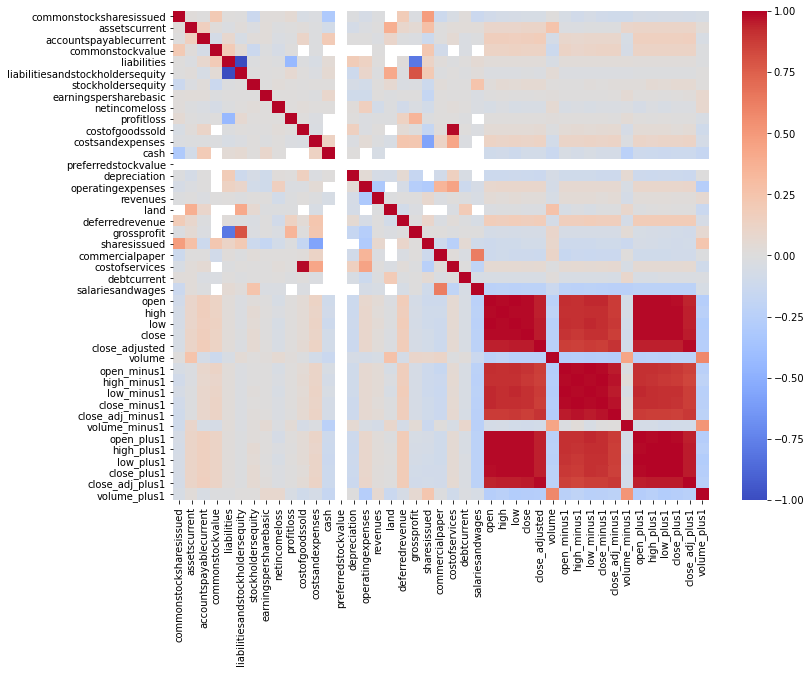

In [31]:
corrmap = df_tri_pctchg.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(round(corrmap,2), ax=ax, cmap="coolwarm")

It's sure different! But if I account for the fact that nothing compares to the way prices correlate to themselves, I think I see some medium-strength correlations between price and items like "deferredrevenue" or "costsandexpenses".

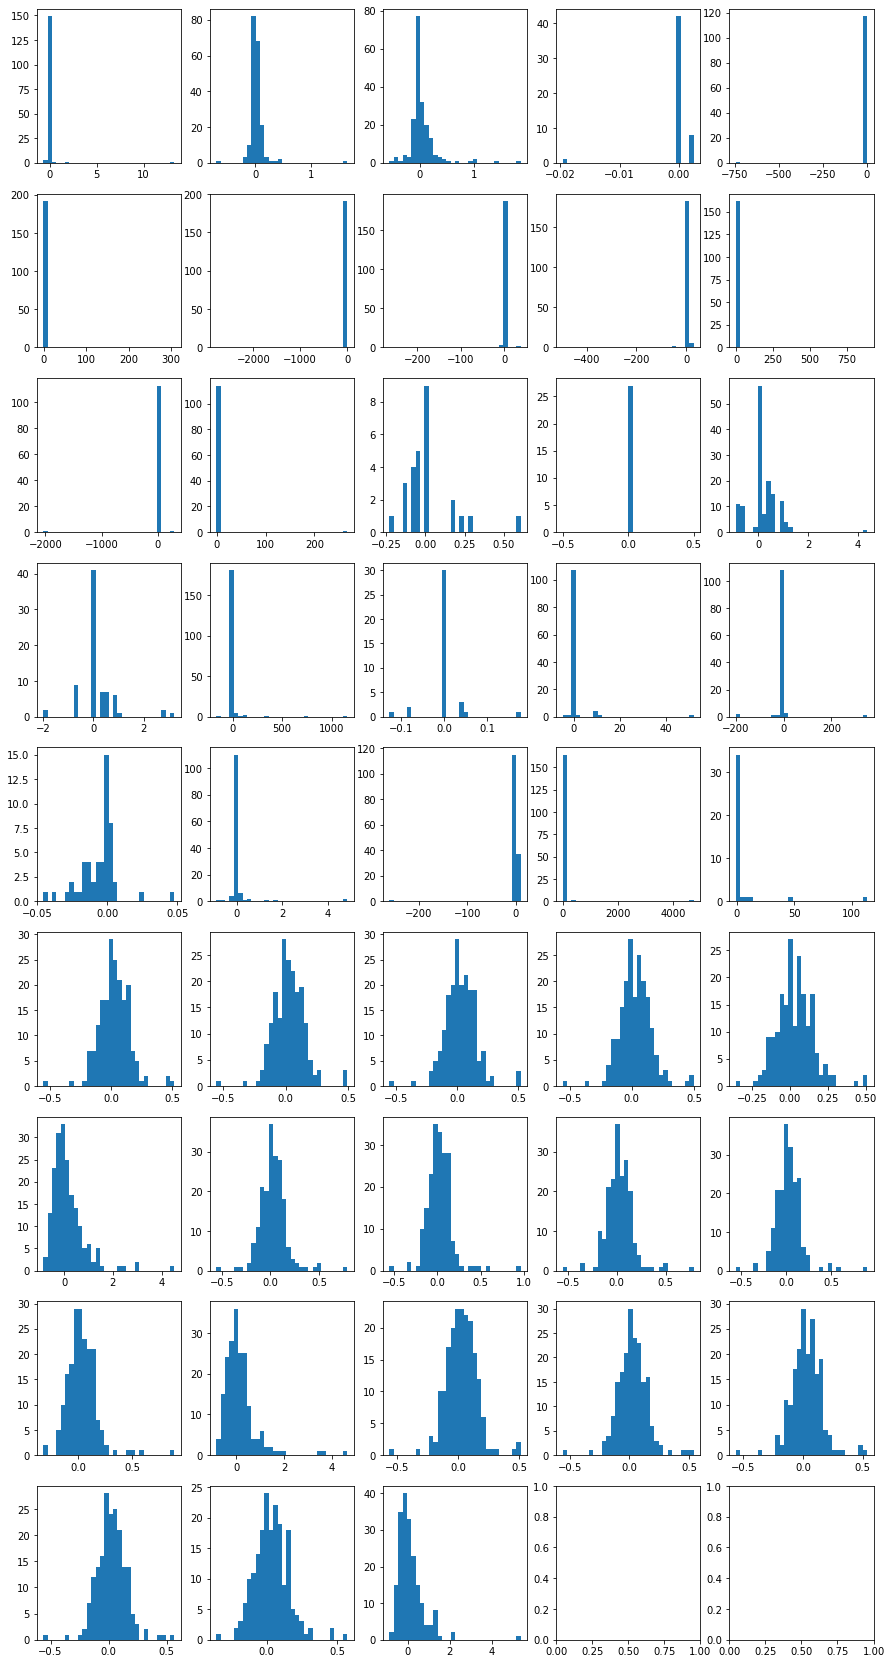

In [36]:
df_tr_numeric = df_tri_pctchg.select_dtypes(include=np.float64)
# axes credit: https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
n_cols = 5
n_rows = int(round(df_tr_numeric.shape[1]/n_cols, 0))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 30))
n_bins = 30

for i, ax in enumerate(axes.flat):
    if i in range(df_tr_numeric.shape[1]):
        ax.hist(df_tr_numeric.iloc[:,i], bins=n_bins)
        ax.xlabel = df_tr_numeric.columns[i]
        # ax.ylabel = 'Count'
   
fig.tight_layout
plt.show()

OMG normalcy appears! Of course, the prettiest ones are probably all the price columns. Still, this looks much more promising.

It does also give me some idea, assuming I count columns, where to look for "outlier" data if I want to. I didn't expect so many of these to have three- or four-digit x-ranges considering that's a 10K-100K percent change.

### I'd better stop here while I'm ahead!
Questions and notes for next chapter in the saga:
- Still, what's the best way to deal with "some companies report column X and some don't" as I head for the ML part of the project? 
- Don't forget to one-hot encode the tickers.
- Figure out outlier data? Or how to ask the ML to ignore anything with a percent-change in the "ridiculous" scale?